## Effect of adding dropout layers:

In this short notebook, we will look at the effects of adding dropout to a simple classification problem.

Paper on dropout.
- https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf

This exercise is inspired by the work of Prof. Jason Brownlee:
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [8]:
# Requirements
import pandas as pd
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


### The dataset 

The dataset is from UCI: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks), and is a collection of raw sonar data. Sonar was bounced of the surface of rocks, as well as metal cylinders, and our task is to classify the two. 

Each datapoint is an array of 60 sonar reading, in the range 0-1, representing the energy of which the sonar reading was recorded. Not a trivial task!

In [2]:
# load dataset
dataframe = pd.read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
x_train = dataset[:,0:60].astype(float)
y_train = dataset[:,60]
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
# Standard scale
std_scale = StandardScaler().fit(x_train)
x_scaled = std_scale.transform(x_train)
# Print the shapes
print(x_scaled.shape, y_train.shape)

(208, 60) (208,)


**Some util functions, don't really focus too much on these**

In [16]:
""" Some util functions """
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

### Baseline model

Before doing anything with dropout layers, lets create a baseline model to compare to. 

The model is a basic sequential model with two dense layers, and one output layer with a sigmoid AF for classification.

The loss will be a binary cross entropy.

In [17]:
# Create baseline_model
baseline_model = Sequential()
baseline_model.add(Dense(60, input_shape=(60,), activation='relu'))
baseline_model.add(Dense(30,  activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))
# Compile baseline_model
sgd = SGD(learning_rate=0.1, momentum=0.9)
baseline_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

**Training** and plotting the results.


....................................................................................................

,loss,accuracy,val_loss,val_accuracy,epoch
99,0.000102,1.0,0.154465,0.904762,99


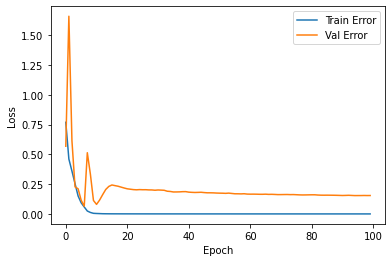

In [18]:
history = baseline_model.fit(x=x_scaled, y=y_train, 
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    verbose=0,
    callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.tail(1))

plot_history(hist)

**As expected**, over time our model will begin overfitting, making the train error drop further, but the validation error stagnate / increase.
But the training accuracy should be around 100%, with a validation accuracy in the range 70-90%.

### Adding dropout to input layer

Now we will try to see the effect of adding a dropout layer - to the input layer! 

Dropout in keras works like this: adding a "dropout layer" will make the previous layer drop nodes at random. 
- So if you want to drop inputs, we need to add dropout as our first layer in the sequential model.



....................................................................................................

,loss,accuracy,val_loss,val_accuracy,epoch
99,0.001481,1.0,0.293163,0.952381,99


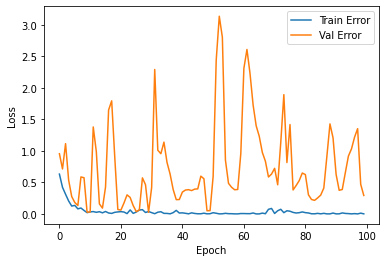

In [27]:
from tensorflow.keras.layers import Dropout

# Define model
p = 0.1 # Dropout rate
model = Sequential()
model.add(Dropout(p, input_shape=(60,)))
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train model
history = model.fit(x=x_scaled, y=y_train, 
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    verbose=0,
    callbacks=[PrintDot()])


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.tail(1))
plot_history(hist)

**Right away** we should notice that both the training loss and validation loss is a lot more "spikey":

This is because: when the model start relying too much on one/some of the 60 inputs, and its suddenly drops, it will have a higher loss for that training sample. Eventually the model will learn to use several inputs and not rely solely on one/few. 

### Add dropout layers to hidden layers

Next we will try to add dropout layers in all hidden layers.


....................................................................................................

,loss,accuracy,val_loss,val_accuracy,epoch
99,0.019966,0.989305,1.340008,0.761905,99


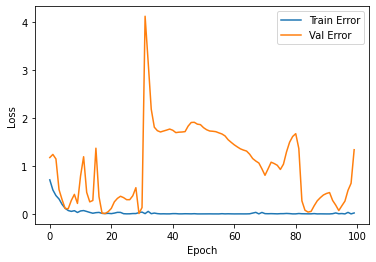

In [26]:
from tensorflow.keras.layers import Dropout

# Define model
p = 0.1 # Dropout rate
model = Sequential()
model.add(Dense(60, input_shape=(60,), activation='relu'))
model.add(Dropout(p))
model.add(Dense(30, activation='relu'))
model.add(Dropout(p))
model.add(Dense(1, activation='sigmoid'))

# Compile model
sgd = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train model
history = model.fit(x=x_scaled, y=y_train, 
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    verbose=0,
    callbacks=[PrintDot()])


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.tail(1))
plot_history(hist)

**Again** we notice the same spikey patterns, even as all input data is available for all training samples in this case.

This is because now, if the model is relying a lot on one / few nodes to extract the right answer, and these nodes are dropped, the loss will spike.

The model will eventually learn to spread out the decision power across all its nodes, and not rely on single / few nodes to make the call.

### Unlocking the full potential of dropout

First of all we will limit the norms of the weights in the dense layers, to 3 - this is due to a suggestion in the [paper](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf).
- This is done to counter extreme "spikey" behaviour in the net. If a node has an extremely large weight attached to it, it means it relies / is relied upon a lot, and will most likely cause a large spike when dropped.

Second, we will increase the net size. A problem with dropout is that we are always training with a net that is reduced by 10-50% in size (depending on dropout rate), and so we should increase the net with the same amount to get as a precise net architecture.

We will also use dropout on both visible and hidden layers.


....................................................................................................

,loss,accuracy,val_loss,val_accuracy,epoch
99,0.045215,0.967914,0.353685,0.809524,99


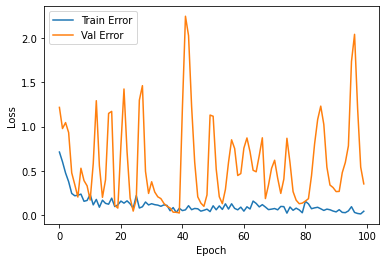

In [29]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm


# Define model
p = 0.2 # Dropout rate
model = Sequential()
model.add(Dropout(p, input_shape=(60,)))
model.add(Dense(60, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(p))
model.add(Dense(60, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(p))
model.add(Dense(1, activation='sigmoid'))

# Compile model
sgd = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train model
history = model.fit(x=x_scaled, y=y_train, 
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    verbose=0,
    callbacks=[PrintDot()])


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.tail(1))
plot_history(hist)

**Still no impressed**?
- The dropout layer will cause a very "spikey" behaviour in loss performance, and sometimes the model in the final iteration will not impress with its val_loss.
- However, it is evident that if we were to "stop the model training" at certain point in the training, we would get a model with both low validation loss and training loss.
- This can be done using a callback function in keras (called "model checkpoint"), which will retrieve the model with the best validation accuracy.
    - Alternatively use the callback "early stopping" which has a function to restore the best weights to the current model


..................Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
17,0.140995,0.962567,0.135012,0.952381,17


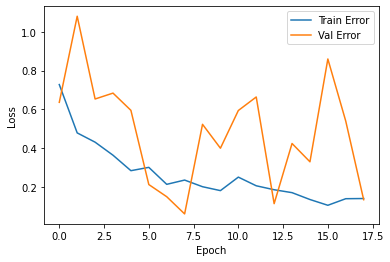

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.callbacks import EarlyStopping

mcp_save = ModelCheckpoint('.best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Define model
p = 0.2 # Dropout rate
model = Sequential()
model.add(Dropout(p, input_shape=(60,)))
model.add(Dense(60, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(p))
model.add(Dense(60, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(p))
model.add(Dense(1, activation='sigmoid'))

# Compile model
sgd = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train model
history = model.fit(x=x_scaled, y=y_train, 
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    verbose=0,
    callbacks=[PrintDot(), mcp_save, early_stopping_monitor])


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.tail(1))
plot_history(hist)